In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get images from visual sensor

In [246]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 12
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!


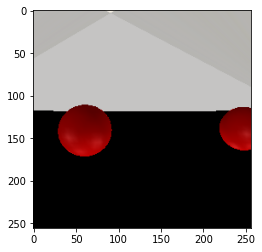

In [247]:
imshow(img)

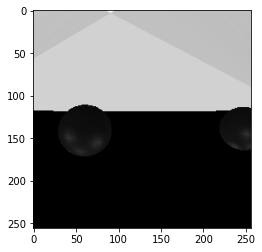

In [248]:
# Convert to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray, cmap='gray')

[[[ 60.5 140.5  30.7]
  [244.5 141.5  27.2]]]


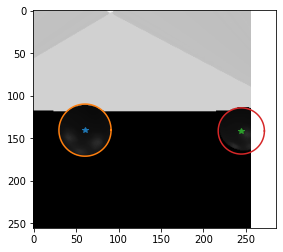

In [249]:
gray = cv2.medianBlur(gray,5)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)

imshow(gray, cmap='gray')
print(circles)
if circles is not None:
    for circle in circles[0, :]:
        center = (circle[0], circle[1])  # In pixels
        radius = circle[2]  # In pixels
        
        # plot circle
        s = linspace(0,2*pi,100)
        cx = cos(s)*radius + center [0]
        cy = sin(s)*radius + center [1]
        # Plot center
        plot(center[0], center[1], '*')
        
        plot(cx,cy)


In [250]:
u0, v0 = 132, 132


k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
fov = 60  # degrees

# number of pixels in x-axis
npx = 264

# maximum value in the x-axis (in meters)
xmax = npx / (2.* k)

# Distance to the center of the sphere (z-axis coordinate)
zc = xmax / tan(pi/6)
zc

# Location of the sphere in the x-axis coordinate
xc = (center[0] - u0) / k
xc

xc, zc

(3.102021971814156, 6.30415533601581)

### Grid representation

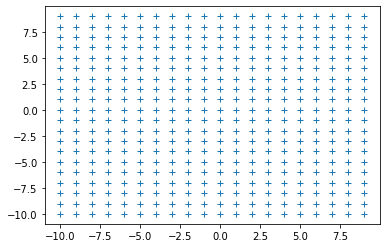

In [251]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

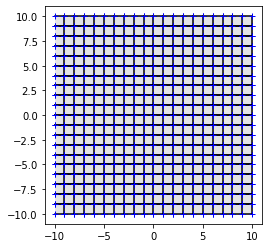

In [252]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

## Use the measurement

In [253]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    #TODO Run this for each sphere (center and radius)
    # Corners of the cell
    X, Y = points_cell(x, y, cell_w)
    # check based on the ecuclidean distance
    dist = sqrt((xc - X)**2 + (zc - Y)**2)
    
    # Check if At least one of the borders is within the sphere
    if((dist < radius/k).any()):
        print(dist)
        po = 0.8  # P(mi/zt) probability of having an obstacle 
        li = log(po / (1-po)) + gmap[i] - l0
        gmap[i] = li  # P(mi/zt) 
        print(li)
    else:
        po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle
        
        # Cells within the fov. Check if the four points are withing the FOV
        thetas = np.arctan2(Y,X) - pi/2
        if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li
           
        pass

# gmap

[1.70741722 1.30813976 0.32080984 1.14322478]
1.3862943611198908
[1.14322478 0.32080984 0.70328392 1.30332353]
1.3862943611198908
[1.30332353 0.70328392 1.69891071 2.02245928]
1.3862943611198908
[1.30813976 1.58340951 0.94809019 0.32080984]
1.3862943611198908
[0.32080984 0.94809019 1.13603008 0.70328392]
1.3862943611198908
[0.70328392 1.13603008 1.91891992 1.69891071]
1.3862943611198908


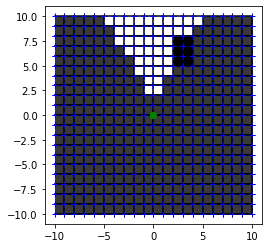

In [254]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()